# Workflow
1. Understand our data better in Exploratory Data Analysis

2. Doing necessary data wrangling. Using sales from Oct 2015 as predictions for Nov 2015(Previous Value Benchmark)

4. Baseline. Apply some variant of decision tree(without any feature engineering, compare this with previous value benchmark)

5. Set up Cross Validation to try out different feature engineering ideas

6. Tuning hyperparameters.

7. Use Ensemble methods to boost score


In [2]:
!pip install keras-tqdm -q

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install keras-rectified-adam -q

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import multiprocessing
import warnings
import os
import gc
import random
import itertools
import pickle
import time
from datetime import datetime
from pathlib import Path
from collections import Counter
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# data preprocessing 
from itertools import product
import pandas as pd
import numpy as np
import missingno
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle

# model
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance

# eveluation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

In [4]:
import tensorflow as tf
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [5]:
from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [6]:
def mean_encoding(data_x, data_y, feature, target):
    data = pd.concat([data_x, data_y], axis=1)
    prior_mean = np.mean(data[target].values)
    enc_value = data.groupby(feature)[target].mean()
    if isinstance(feature, list):
        feature_name = 'enc_' + '_'.join(feature)
        data_x[feature_name] = data_x[f].join(pd.DataFrame(enc_value), on=feature, how='left')[target]
    else:
        feature_name = 'enc_' + feature
        data_x[feature_name] = data_x[feature].map(enc_value)    
    return data_x, enc_value, prior_mean, feature_name

def smooth_mean_encoding(data_x, data_y, feature, target, min_samples=1, smooth_method='stats_smooth'):
    data = pd.concat([data_x, data_y], axis=1)
    nrows = data.groupby(feature)[target].count()
    target_mean = data.groupby(feature)[target].mean()
    prior_mean = np.mean(data[target].values)    
    if smooth_method == 'stats_smooth':
        smooth_enc_value = (target_mean * nrows + prior_mean * min_samples) / (nrows + min_samples) 
    elif smooth_method == 'sigmoid_smooth':
        smoothing_slope = 1
        smooth_factor = 1 / (1 + np.exp(- (nrows - min_samples) / smoothing_slope))
        smooth_enc_value = smooth_factor * target_mean + (1 - smooth_factor) * prior_mean        
    if isinstance(feature, list):
        feature_name = 'smooth_enc_' + '_'.join(feature)
        data_x[feature_name] = data_x[f].join(pd.DataFrame(smooth_enc_value), on=feature, how='left')[target]
    else:
        feature_name = 'smooth_enc_' + feature
        data_x[feature_name] = data_x[feature].map(smooth_enc_value)          
    return data_x, smooth_enc_value, prior_mean, feature_name

def beta_mean_encoding(data, feature, target, stats, prior_mean, N_min=5):
    df_stats = pd.merge(data[[feature]], stats, how='left', on=feature)
    df_stats['sum'].fillna(value=prior_mean, inplace = True)
    df_stats['count'].fillna(value=1.0, inplace = True)    
    N_prior = np.maximum(N_min - df_stats['count'].values, 0)   # prior parameters
    df_stats[feature_name] = (prior_mean * N_prior + df_stats['sum']) / (N_prior + df_stats['count']) # Bayesian mean
    
    if isinstance(feature, list):
        feature_name = 'mec_' + '_'.join(feature)
        data[feature_name] = df_stats[feature_name].values
    else:
        feature_name = 'mec_' + feature
        data[feature_name] = df_stats[feature_name].values         
    return data, feature_name

In [16]:
predict_future_sales_path = Path('../input/competitive-data-science-predict-future-sales')

item_categories_data = pd.read_csv(str(predict_future_sales_path / 'item_categories.csv'), 
                                   dtype={'item_category_name': 'str', 
                                          'item_category_id': 'int32'})
items_data = pd.read_csv(str(predict_future_sales_path / 'items.csv'), 
                         dtype={'item_name': 'str', 
                                'item_id': 'int32', 
                                'item_category_id': 'int32'})

sales_data = pd.read_csv(str(predict_future_sales_path / 'sales_train.csv'),
                         dtype={'date': 'str', 
                                'date_block_num': 'int32', 
                                'shop_id': 'int32', 
                                'item_id': 'int32', 
                                'item_price': 'float32', 
                                'item_cnt_day': 'int32'})

shop_data = pd.read_csv(str(predict_future_sales_path / 'shops.csv'),
                        dtype={'shop_name': 'str', 
                               'shop_id': 'int32'})

test_data = pd.read_csv(str(predict_future_sales_path / 'test.csv'),
                        dtype={'ID': 'int32', 
                               'shop_id': 'int32', 
                               'item_id': 'int32'})
test_data.set_index('ID', inplace=True)

In [3]:
print('Number of train data:{} \nNumber of test data:{}'.format(sales_data.shape[0], test_data.shape[0]))


Number of train data:2935849 
Number of test data:214200


In [4]:
good_sales = test_data.merge(sales_data, on=['item_id', 'shop_id'], how='left').dropna()
good_pairs = test_data[test_data['ID'].isin(good_sales['ID'])]
no_data_items = test_data[~(test_data['item_id'].isin(sales_data['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test_data)-len(no_data_items)-len(good_pairs))

1. Number of good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550


# Data Preprocessing


***Check missing value***

In [17]:
sales_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [18]:
sales_data.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

***Remove outlier***

In [20]:
sales_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


(-22, 2385.9)

(-1.0, 338778.0)

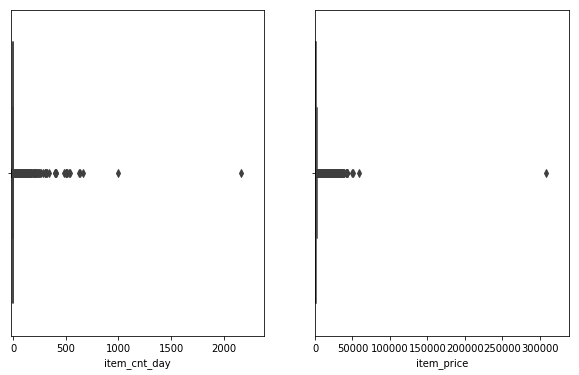

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(x=sales_data['item_cnt_day'], ax=ax[0])
ax[0].set_xlim([sales_data.item_cnt_day.min(), sales_data.item_cnt_day.max()*1.1])  

sns.boxplot(x=sales_data['item_price'], ax=ax[1])
ax[1].set_xlim([sales_data.item_price.min(), sales_data.item_price.max()*1.1])  

plt.show()

In [22]:
sales_data = sales_data[sales_data.item_price < 100000]
sales_data = sales_data[sales_data.item_cnt_day < 1000]

# replace the NA value of item price 
condition = (sales_data.shop_id == 32) & (sales_data.item_id == 2973)
sales_data.loc[sales_data.item_price < 0, 'item_price'] = sales_data[condition]['item_price'].median()

print('How many number of item_price less than 0:{}'.format(sales_data[sales_data.item_price < 0].shape[0]))   
print('How many number of item_cnt_day less than 0: {}'.format(sales_data[sales_data.item_cnt_day < 0].shape[0]))

How many number of item_price less than 0:0
How many number of item_cnt_day less than 0: 7356


***Shops / Cats / Items preprocessing***

In [23]:
# shop id 0 is as same as 57,  Якутск Орджоникидзе, 56
# shop id 1 is as same as 58,  Якутск ТЦ "Центральный"
# shop id 10 is as same as 11, Жуковский ул. Чкалова 39м²
# change the shop_id
sales_data.loc[sales_data.shop_id == 0, 'shop_id'] = 57
test_data.loc[test_data.shop_id == 0, 'shop_id'] = 57

sales_data.loc[sales_data.shop_id == 1, 'shop_id'] = 58
test_data.loc[test_data.shop_id == 1, 'shop_id'] = 58

sales_data.loc[sales_data.shop_id == 10, 'shop_id'] = 11
test_data.loc[test_data.shop_id == 10, 'shop_id'] = 11


In [24]:
print(shop_data.shape, items_data.shape, item_categories_data.shape, sales_data.shape, test_data.shape)

(60, 2) (22170, 3) (84, 2) (2935846, 6) (214200, 3)


In [25]:
shop_data.loc[shop_data.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shop_data['city'] = shop_data['shop_name'].apply(lambda x:x.split(' ')[0])
shop_data.loc[shop_data.city == '!Якутск', 'city'] = 'Якутск'

label_encoder = LabelEncoder()
shop_data['city_code'] = label_encoder.fit_transform(shop_data['city'])
shop_data = shop_data[['shop_id', 'city_code']]

In [26]:
# splite item categories name to get item type
item_categories_data['split'] = item_categories_data['item_category_name'].apply(lambda x:x.split('-'))
item_categories_data['type'] = item_categories_data['split'].apply(lambda x:x[0].strip())
item_categories_data['type_code'] = LabelEncoder().fit_transform(item_categories_data['type'])

item_categories_data['subtype'] = item_categories_data['split'].apply(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories_data['subtype_code'] = LabelEncoder().fit_transform(item_categories_data['subtype'])
item_categories_data = item_categories_data[['item_category_id', 'type_code', 'subtype_code']]

items_data.drop(['item_name'], axis=1, inplace=True)

In [28]:
sales_data['revenue'] = sales_data['item_price'] * sales_data['item_cnt_day']

For every month we create a grid from all shops/items combinations from that month

In [37]:
%%time
matrix = []
cols = ['date_block_num', 'shop_id','item_id']
for i in range(34):
    sales = sales_data[sales_data.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)


In [39]:
print('Number of complete month of year for each shop_id and item_id: {}'.format(matrix.shape[0]))

Number of complete month of year for each shop_id and item_id: 10913804


In [40]:
# data check
condition = (matrix.shop_id == 0) & (matrix.item_id == 0)
matrix[condition]

,date_block_num,shop_id,item_id


**Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.**

In [41]:
groupby_cols = ['shop_id', 'item_id', 'date_block_num']
train_df = sales_data.groupby(groupby_cols).agg({
    'item_cnt_day':['sum']
}).reset_index()

train_df.columns = ['_'.join(cols).strip() for cols in train_df.columns.values]
train_df.rename({
    'shop_id_': 'shop_id',
    'item_id_': 'item_id',
    'date_block_num_': 'date_block_num',
    'item_cnt_day_sum': 'item_cnt_month'
}, inplace=True, axis=1)

matrix = pd.merge(matrix, train_df, on=groupby_cols, how='left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16)
                            

*merge other data info*

In [42]:
matrix = pd.merge(matrix, shop_data, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items_data, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories_data, on=['item_category_id'], how='left')

matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [43]:
test_data['date_block_num'] = 34
test_data['date_block_num'] = test_data['date_block_num'].astype(np.int8)
test_data['shop_id'] = test_data['shop_id'].astype(np.int8)
test_data['item_id'] = test_data['item_id'].astype(np.int16)

In [44]:
matrix = pd.concat([matrix, test_data], ignore_index=True, sort=False, keys=groupby_cols)
matrix.fillna(0, inplace=True)

In [45]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,ID
0,0,2,19,0.0,0.0,40.0,11.0,4.0,0.0
1,0,2,27,1.0,0.0,19.0,5.0,10.0,0.0
2,0,2,28,0.0,0.0,30.0,8.0,55.0,0.0
3,0,2,29,0.0,0.0,23.0,5.0,16.0,0.0
4,0,2,32,0.0,0.0,40.0,11.0,4.0,0.0


In [46]:
print('Number of train + test data:{}'.format(matrix.shape[0]))

Number of train + test data:11128004


In [47]:
with open('all_month_data.pkl', 'wb') as handle:
    pickle.dump(matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Feature engineering

*Target lags*

Lag 為此次比賽的關鍵 feature，因為是要預測下一個月的總量，所以用 Lags 可以彌補 `date_block_num:34` 所需要的資料

In [49]:
lags_list = list(range(1, 13))

def lag_feature(df, lags, col):
    start_time = time.time()
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        del shifted
    end_time = time.time()    
    print('Computing time:{}'.format(end_time - start_time))
    return df

In [50]:
matrix = lag_feature(matrix, lags_list, 'item_cnt_month')


Computing time:144.4366819858551


### Group based lag features 

In [51]:
def do_count(data, group_cols, target_col, new_col_name, col_type):
    print('[INFO] Count {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
    cols = group_cols.copy()
    cols.append(target_col)
    group_data = data[cols].groupby(by=group_cols)[[target_col]].count()\
        .reset_index()\
        .rename(index=str, columns={target_col: new_col_name})
    data = data.merge(group_data, on=group_cols, how='left')
    del group_data
    data[new_col_name] = data[new_col_name].astype(col_type)
    gc.collect()
    return data
    
def do_mean(data, group_cols, target_col, new_col_name, col_type):
    print('[INFO] Compute mean {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
    cols = group_cols.copy()
    cols.append(target_col)
    group_data = data[cols].groupby(by=group_cols)[[target_col]].mean()\
        .reset_index().rename(index=str, columns={target_col: new_col_name})
    data = data.merge(group_data, on=group_cols, how='left')
    del group_data
    data[new_col_name] = data[new_col_name].astype(col_type)
    gc.collect()
    return data

def do_sum(data, group_cols, target_col, new_col_name, col_type):
    print('[INFO] Compute mean {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
    cols = group_cols.copy()
    cols.append(target_col)
    group_data = data[cols].groupby(by=group_cols)[[target_col]].sum()\
        .reset_index().rename(index=str, columns={target_col: new_col_name})
    data = data.merge(group_data, on=group_cols, how='left')
    del group_data
    data[new_col_name] = data[new_col_name].astype(col_type)
    gc.collect()
    return data

def do_max(data, group_cols, target_col, new_col_name, col_type):
    print('[INFO] Compute mean {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
    cols = group_cols.copy()
    cols.append(target_col)
    group_data = data[cols].groupby(by=group_cols)[[target_col]].max()\
        .reset_index().rename(index=str, columns={target_col: new_col_name})
    data = data.merge(group_data, on=group_cols, how='left')
    del group_data
    data[new_col_name] = data[new_col_name].astype(col_type)
    gc.collect()
    return data

def do_min(data, group_cols, target_col, new_col_name, col_type):
    print('[INFO] Compute mean {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
    cols = group_cols.copy()
    cols.append(target_col)
    group_data = data[cols].groupby(by=group_cols)[[target_col]].min()\
        .reset_index().rename(index=str, columns={target_col: new_col_name})
    data = data.merge(group_data, on=group_cols, how='left')
    del group_data
    data[new_col_name] = data[new_col_name].astype(col_type)
    gc.collect()
    return data

In [52]:
group_cols = ['date_block_num']
target_col = 'item_cnt_month'
new_col_name = 'date_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num combination...
Computing time:13.271844625473022


In [53]:
group_cols = ['date_block_num', 'item_id']
target_col = 'item_cnt_month'
new_col_name = 'date_item_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, lags_list, new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-item_id combination...
Computing time:160.10187125205994


In [54]:
group_cols = ['date_block_num', 'shop_id']
target_col = 'item_cnt_month'
new_col_name = 'date_shop_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, lags_list, new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-shop_id combination...
Computing time:170.39596271514893


In [55]:
group_cols = ['date_block_num', 'item_category_id']
target_col = 'item_cnt_month'
new_col_name = 'date_cat_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-item_category_id combination...
Computing time:17.533079147338867


In [56]:
group_cols = ['date_block_num', 'shop_id', 'item_category_id']
target_col = 'item_cnt_month'
new_col_name = 'date_shop_cat_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-shop_id-item_category_id combination...
Computing time:17.784915685653687


In [57]:
group_cols = ['date_block_num', 'shop_id', 'type_code']
target_col = 'item_cnt_month'
new_col_name = 'date_shop_type_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-shop_id-type_code combination...
Computing time:17.237791538238525


In [58]:
group_cols = ['date_block_num', 'shop_id', 'subtype_code']
target_col = 'item_cnt_month'
new_col_name = 'date_city_subtype_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-shop_id-subtype_code combination...
Computing time:17.892373085021973


In [59]:
group_cols = ['date_block_num', 'city_code']
target_col = 'item_cnt_month'
new_col_name = 'date_city_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-city_code combination...
Computing time:17.715256214141846


In [60]:
group_cols = ['date_block_num', 'item_id', 'city_code']
target_col = 'item_cnt_month'
new_col_name = 'date_item_city_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-item_id-city_code combination...
Computing time:18.783292293548584


In [61]:
group_cols = ['date_block_num', 'type_code']
target_col = 'item_cnt_month'
new_col_name = 'date_type_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-type_code combination...
Computing time:19.222887754440308


In [62]:
group_cols = ['date_block_num', 'subtype_code']
target_col = 'item_cnt_month'
new_col_name = 'date_subtype_avg_item_cnt_month'
col_type = 'float16'

matrix = do_mean(data=matrix,
                   group_cols=group_cols,
                   target_col=target_col,
                   new_col_name=new_col_name,
                   col_type=col_type)

matrix = lag_feature(matrix, [1], new_col_name)
matrix.drop([new_col_name], axis=1, inplace=True)


[INFO] Compute mean item_cnt_month with group by date_block_num-subtype_code combination...
Computing time:18.79897427558899


***Trend features***

Price trend for the last six months.

In [63]:
group_cols = ['item_id']
target_col = 'item_price'
new_col_name = 'item_avg_item_price'
col_type = 'float16'

sales_data = do_mean(data=sales_data,
                     group_cols=group_cols,
                     target_col=target_col,
                     new_col_name=new_col_name,
                     col_type=col_type)

tmp_data = sales_data[group_cols + [new_col_name]].drop_duplicates()
matrix = pd.merge(matrix, tmp_data, on=group_cols, how='left')
del tmp_data
gc.collect()

[INFO] Compute mean item_price with group by item_id combination...


35

In [64]:
group_cols = ['date_block_num', 'item_id']
target_col = 'item_price'
new_col_name = 'date_item_avg_item_price'
col_type = 'float16'

sales_data = do_mean(data=sales_data,
                     group_cols=group_cols,
                     target_col=target_col,
                     new_col_name=new_col_name,
                     col_type=col_type)

tmp_data = sales_data[group_cols + [new_col_name]].drop_duplicates()
matrix = pd.merge(matrix, tmp_data, on=group_cols, how='left')
del tmp_data
gc.collect()

[INFO] Compute mean item_price with group by date_block_num-item_id combination...


35

In [65]:
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, new_col_name)


Computing time:95.3943612575531


In [66]:
for i in lags:
    matrix['delta_price_lag_' + str(i)] = (matrix['date_item_avg_item_price_lag_'+ str(i)] - 
                                             matrix['item_avg_item_price']) / matrix['item_avg_item_price']
    

In [67]:
delta_cols = [i for i in matrix.columns.tolist() if i.startswith('delta_price_lag_')]

In [68]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+ str(i)]:
            return row['delta_price_lag_'+ str(i)]
    return 0

matrix['delta_price_lag'] = matrix[delta_cols].apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [69]:
fetures_to_drop = ['date_item_avg_item_price', 'item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_' + str(i)]
    fetures_to_drop += ['delta_price_lag_' + str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)
gc.collect()

140

***Last month shop revenue trend***

In [70]:
group_cols = ['date_block_num', 'shop_id']
target_col = 'revenue'
new_col_name = 'date_shop_revenue'
col_type = 'float32'

sales_data = do_sum(data=sales_data,
                    group_cols=group_cols,
                    target_col=target_col,
                    new_col_name=new_col_name,
                    col_type=col_type)

[INFO] Compute mean revenue with group by date_block_num-shop_id combination...


In [71]:
tmp_data = sales_data[group_cols + [new_col_name]].drop_duplicates()
matrix = pd.merge(matrix, tmp_data, on=group_cols, how='left')
del tmp_data
gc.collect()

35

In [72]:
group_cols = ['shop_id']
target_col = 'revenue'
new_col_name = 'shop_avg_revenue'
col_type = 'float32'

sales_data = do_mean(data=sales_data,
                     group_cols=group_cols,
                     target_col=target_col,
                     new_col_name=new_col_name,
                     col_type=col_type)

tmp_data = sales_data[group_cols + [new_col_name]].drop_duplicates()
matrix = pd.merge(matrix, tmp_data, on=group_cols, how='left')
del tmp_data
gc.collect()

[INFO] Compute mean revenue with group by shop_id combination...


35

In [73]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'delta_revenue')
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)


Computing time:18.989776611328125


*add month and day featue*

In [74]:
matrix['month'] = matrix['date_block_num'] % 12


In [100]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Create HashTable with key equals to `{shop_id, item_id}` and value equals to date_block_num. Iterate data from the top. Foreach row if `{row.shop_id,row.item_id}` is not present in the table, then add it to the table and set its value to row.date_block_num. If HashTable contains key, then calculate the difference beteween cached value and `row.date_block_num`.

In [103]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id) + '_' + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         


In [104]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month! = 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num  

In [107]:
del cache
gc.collect()

2832

In [9]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [ ]:
matrix = matrix[matrix.date_block_num > 11]

In [ ]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)


In [12]:
# Save data with feature engineering
with open('all_month_data_with_fe.pkl', 'wb') as handle:
    pickle.dump(matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Building model


In [7]:
with open('all_month_data_with_fe.pkl', 'rb') as handle:
    matrix = pickle.load(handle)

In [14]:
matrix.shape

(6639294, 62)

In [18]:
features_cols = [c for c in matrix.columns.tolist() if c not in ['item_cnt_month', 'ID']]
target_col = 'item_cnt_month'
cat_features = ['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id', 
                'type_code', 'subtype_code']

# Baseline model

In [15]:
train_df = matrix[matrix.date_block_num < 33]
valid_df = matrix[matrix.date_block_num == 33]
test_df = matrix[matrix.date_block_num == 34]

In [16]:
num_of_iter = 1000
num_early_stopping = 20
num_verbose_eval = 100
seed = 9527
metric = 'rmse'
    
xgb_sk_params = {
    'learning_rate': 0.3,
    'n_estimators': num_of_iter,                                   
    'objective': 'reg:squarederror', # binary:logistic
    'n_jobs': multiprocessing.cpu_count(),
    'eval_metric': [metric], # logloss
    'random_state':  seed,
    'max_depth': 8, # 0 means no limit (useful only for depth wise grow policy).
    'min_child_weight': 300, # Minimum sum of instance weight (hessian) needed in a child.
    'subsample': 0.8, # Subsample ratio of the training instances.
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing each tree.
}

lgb_sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,
    'objective': 'regression_l2',
    'metrics': [metric],
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),

}

## XGBoost

In [19]:
eval_set = [(train_df[features_cols], train_df[target_col]),
            (valid_df[features_cols], valid_df[target_col])]
model = xgb.XGBRegressor(**xgb_sk_params)
model.fit(X=train_df[features_cols],
          y=train_df[target_col], 
          eval_set=eval_set,             
          early_stopping_rounds=num_early_stopping, 
          verbose=num_verbose_eval)
      

[06:29:43] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.0728	validation_1-rmse:1.06573
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
Stopping. Best iteration:
[8]	validation_0-rmse:0.831928	validation_1-rmse:0.913173



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric=['rmse'],
             gamma=0, importance_type='gain', learning_rate=0.3,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
             n_estimators=1000, n_jobs=8, nthread=None,
             objective='reg:squarederror', random_state=9527, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8, verbosity=1)

In [ ]:
y_pred = model.predict(valid_df[features_cols], ntree_limit=model.best_iteration_)

print('MSE:', mean_squared_error(valid_df[target_col], y_pred))
print('RMSE:', np.sqrt(mean_squared_error(valid_df[target_col], y_pred)))
print('R2 score:', r2_score(valid_df[target_col], y_pred))    

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(model, importance_type='weight', max_num_features=-1, height=0.5, ax=ax)

## LightGBM

In [30]:
eval_set = [(train_df[features_cols], train_df[target_col]),
            (valid_df[features_cols], valid_df[target_col])]
model = lgb.LGBMRegressor(**lgb_sk_params)    
model.fit(X=train_df[features_cols],
          y=train_df[target_col], 
          eval_set=eval_set, 
          eval_names=['validation_0', 'validation_1'],
          early_stopping_rounds=num_early_stopping, 
          verbose=num_verbose_eval)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	validation_0's rmse: 0.859803	validation_1's rmse: 0.940769


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metrics=['rmse'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=8, num_leaves=31,
              objective='regression_l2', random_state=9527, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [32]:
y_pred = model.predict(valid_df[features_cols], ntree_limit=model.best_iteration_)

print('MSE:', mean_squared_error(valid_df[target_col], y_pred))
print('RMSE:', np.sqrt(mean_squared_error(valid_df[target_col], y_pred)))
print('R2 score:', r2_score(valid_df[target_col], y_pred))    

MSE: 0.8850470959300232
RMSE: 0.9407694169827286
R2 score: 0.31425523196476757


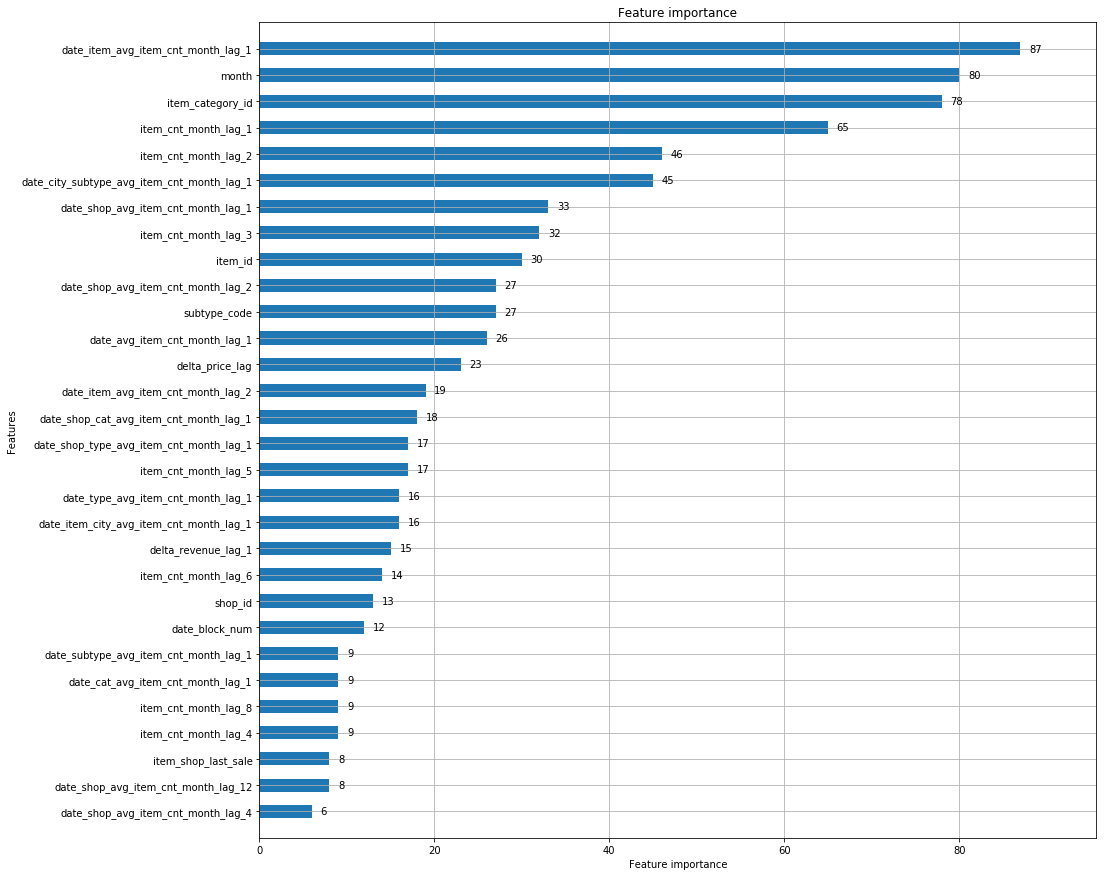

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
lgb.plot_importance(model, max_num_features=30, height=0.5, importance_type='split', ax=ax)

In [98]:
y_pred = model.predict(test_df[features_cols],
                       ntree_limit=model.best_iteration)
y_pred = y_pred.clip(0, 20)
submission_df = pd.DataFrame({
    "ID": list(range(test_df.shape[0])), 
    "item_cnt_month": y_pred
})
submission_df.to_csv('submission_bs_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M%S')), index=False)

# Cross validation with time split

In [34]:
train_df = matrix[matrix.date_block_num <= 33]
test_df = matrix[matrix.date_block_num == 34]

In [176]:
num_of_iter = 1000
num_early_stopping = 50
num_verbose_eval = 100
seed = 9527
metric = 'rmse'
    
xgb_sk_params = {
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,                                   
    'objective': 'reg:squarederror', # binary:logistic
    'n_jobs': multiprocessing.cpu_count(),
    #'tree_method': "gpu_hist",  # gpu_hist
    #'n_gpus': -1,
    'eval_metric': [metric], # logloss
    'random_state':  seed,
    #'gamma': 0, # Minimum loss reduction required to make a further partition on a leaf node of the tree, alias min_split_loss. It acts as a regularization parameter. Either 0, 1 or 5.
    #'max_depth': 8, # 0 means no limit (useful only for depth wise grow policy).
    #'min_child_weight': 300, # Minimum sum of instance weight (hessian) needed in a child.
    #'subsample': 0.8, # Subsample ratio of the training instances.
    #'colsample_bytree': 0.8, # subsample ratio of columns when constructing each tree.
    #'colsample_bylevel': 1, # subsample ratio of columns for each level.
    #'reg_lambda': 1e-3, # L2 regularization. Increasing this value will make model more conservative.
    #'reg_alpha': 0, # L1 regularization. Increasing this value will make model more conservative.
    #'scale_pos_weight': weight_ratio, # Control the balance of positive and negative weights, useful for unbalanced classes.
    #'grow_policy': "lossguide", # split at nodes with highest loss change.
    #'max_leaves': 255, # Maximum number of nodes to be added. (for lossguide grow policy).
    #'max_bin': 100, # Increasing this number improves the optimality of splits at the cost of higher computation time.
}

lgb_sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    #'num_leaves': 80,
    #'max_depth': 5,
    'learning_rate': 0.0010151324067998776,
    'n_estimators': num_of_iter,
    #'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'objective': 'regression_l2',
    'metrics': [metric],
    #'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    #'min_child_weight': 1,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    #'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    #'subsample': 0.8,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 3,  # L1 regularization term on weights
    #'reg_lambda': 1e-3,
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),
    #'scale_pos_weight': 0.5,
    #'max_bin': 255
}

In [177]:
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)
#folds = TimeSeriesSplit(n_splits=n_splits)
#Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()
total_fold_loss_df = pd.DataFrame()
y_true = test_df[target_col].values.tolist()
y_pred = np.zeros(test_df.shape[0])
test_acc_score = []
test_auc_score = []
target_encoding_cols = ['date_block_num', 'shop_id', 'item_id']
mean_enc = None
model_name = 'lgb'

for fold, (trn_idx, val_idx) in enumerate(Kflods):
    print("===== Fold {} =====".format(fold))
    trn_idx = shuffle(trn_idx)
    train_x, train_y = train_df.iloc[trn_idx][features_cols], train_df.iloc[trn_idx][target_col]
    valid_x, valid_y = train_df.iloc[val_idx][features_cols], train_df.iloc[val_idx][target_col]
    features_cols_v2 = features_cols.copy()
    if mean_enc == 'mean':
        for f in target_encoding_cols:
            train_x, enc_value, prior_mean, feature_name = mean_encoding(train_x, train_y, f, target_col)
            valid_x[feature_name] = valid_x[f].map(enc_value)
            valid_x[feature_name].fillna(prior_mean, inplace=True)    
            test_df[feature_name] = test_df[f].map(enc_value)
            test_df[feature_name].fillna(prior_mean, inplace=True)
            features_cols_v2.remove(f)
            features_cols_v2.append(feature_name)
    elif mean_enc == 'smooth':
        for f in target_encoding_cols:
            train_x, enc_value, prior_mean, feature_name = smooth_mean_encoding(train_x, train_y, f, target_col)
            valid_x[feature_name] = valid_x[f].map(enc_value)
            valid_x[feature_name].fillna(prior_mean, inplace=True)    
            test_df[feature_name] = test_df[f].map(enc_value)
            test_df[feature_name].fillna(prior_mean, inplace=True)
            features_cols_v2.append(feature_name)
    elif mean_enc == 'beta':
        prior_mean = np.mean(train_y)
        for f in target_encoding_cols:
            stats = train_df.iloc[trn_idx].groupby(f).agg(['sum', 'count'])['label'].reset_index()
            train_x, feature_name = beta_mean_encoding(train_x, f, target_col, stats, prior_mean)
            valid_x, _ = beta_mean_encoding(valid_x, f, target_col, stats, prior_mean)
            test_df, _ = beta_mean_encoding(test_df, f, target_col, stats, prior_mean)
            features_cols_v2.append(feature_name)

    eval_set = [(train_x[features_cols_v2], train_y), (valid_x[features_cols_v2], valid_y)]
    if model_name == 'xgb':
        xgb_sk_params.update({'random_state': fold + np.random.randint(999) + seed})
        cv_model = xgb.XGBRegressor(**xgb_sk_params)
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y, 
                     eval_set=eval_set,             
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval) 
        loss = cv_model.evals_result().items()
    elif model_name == 'lgb':
        lgb_sk_params.update({'random_state': fold + np.random.randint(999) + seed})
        cv_model = lgb.LGBMRegressor(**lgb_sk_params)    
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y, 
                     eval_set=eval_set,    
                     eval_names=['validation_0', 'validation_1'],
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval) 
        loss = cv_model.evals_result_.items()
    
    # loss 
    fold_loss_df = pd.DataFrame(columns=['fold', 'type', 'loss'])
    for k, v in loss:
        if k == 'validation_0':        
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'train'                
        elif k == 'validation_1':
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'valid'                
        total_fold_loss_df = pd.concat([total_fold_loss_df, fold_loss_df], axis=0)
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_cols_v2
    fold_importance_df["importance"] = cv_model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # evaluation
    if model_name == 'xgb':
        oof[val_idx] += cv_model.predict(valid_x[features_cols_v2], 
                                         ntree_limit=cv_model.best_iteration)
        y_pred += cv_model.predict(test_df[features_cols_v2], 
                                   ntree_limit=cv_model.best_iteration) / folds.n_splits
    elif model_name == 'lgb':
        oof[val_idx] += cv_model.predict(valid_x[features_cols_v2], 
                                               ntree_limit=cv_model.best_iteration_)
        y_pred += cv_model.predict(test_df[features_cols_v2], 
                                         ntree_limit=cv_model.best_iteration_) / folds.n_splits
        
    print()
    print('MSE:', mean_squared_error(valid_y, oof[val_idx]))
    print('RMSE:', np.sqrt(mean_squared_error(valid_y, oof[val_idx])))
    print('R2 score:', r2_score(valid_y, oof[val_idx]))

print('---------------------------')
print('MSE:', mean_squared_error(train_df[target_col], oof))
print('RMSE:', np.sqrt(mean_squared_error(train_df[target_col], oof)))
print('R2 score:', r2_score(train_df[target_col], oof))    
       

===== Fold 0 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.14219	validation_1's rmse: 1.14307
[200]	validation_0's rmse: 1.10288	validation_1's rmse: 1.1043
[300]	validation_0's rmse: 1.06921	validation_1's rmse: 1.07111
[400]	validation_0's rmse: 1.0406	validation_1's rmse: 1.04294
[500]	validation_0's rmse: 1.01607	validation_1's rmse: 1.01876
[600]	validation_0's rmse: 0.995053	validation_1's rmse: 0.998082
[700]	validation_0's rmse: 0.977017	validation_1's rmse: 0.980329
[800]	validation_0's rmse: 0.961582	validation_1's rmse: 0.965132
[900]	validation_0's rmse: 0.948353	validation_1's rmse: 0.952134
[1000]	validation_0's rmse: 0.936986	validation_1's rmse: 0.941028
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.936986	validation_1's rmse: 0.941028


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.0010151324067998776,
              max_depth=-1, metrics=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=8, num_leaves=31, objective='regression_l2',
              random_state=9569, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


MSE: 0.8855329603973645
RMSE: 0.9410276087327961
R2 score: 0.37317718323490723
===== Fold 1 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.14232	validation_1's rmse: 1.14249
[200]	validation_0's rmse: 1.10316	validation_1's rmse: 1.10327
[300]	validation_0's rmse: 1.06962	validation_1's rmse: 1.06973
[400]	validation_0's rmse: 1.04107	validation_1's rmse: 1.04114
[500]	validation_0's rmse: 1.01662	validation_1's rmse: 1.01668
[600]	validation_0's rmse: 0.995685	validation_1's rmse: 0.995732
[700]	validation_0's rmse: 0.977722	validation_1's rmse: 0.977741
[800]	validation_0's rmse: 0.962325	validation_1's rmse: 0.962328
[900]	validation_0's rmse: 0.94918	validation_1's rmse: 0.949172
[1000]	validation_0's rmse: 0.937873	validation_1's rmse: 0.937852
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.937873	validation_1's rmse: 0.937852


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.0010151324067998776,
              max_depth=-1, metrics=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=8, num_leaves=31, objective='regression_l2',
              random_state=9936, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


MSE: 0.8795654444230848
RMSE: 0.937851504462772
R2 score: 0.3773971988164574
===== Fold 2 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.14252	validation_1's rmse: 1.14169
[200]	validation_0's rmse: 1.10349	validation_1's rmse: 1.10192
[300]	validation_0's rmse: 1.07019	validation_1's rmse: 1.06802
[400]	validation_0's rmse: 1.04177	validation_1's rmse: 1.03912
[500]	validation_0's rmse: 1.01745	validation_1's rmse: 1.01447
[600]	validation_0's rmse: 0.996533	validation_1's rmse: 0.993228
[700]	validation_0's rmse: 0.97857	validation_1's rmse: 0.974955
[800]	validation_0's rmse: 0.963192	validation_1's rmse: 0.959341
[900]	validation_0's rmse: 0.950026	validation_1's rmse: 0.945987
[1000]	validation_0's rmse: 0.938717	validation_1's rmse: 0.934534
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.938717	validation_1's rmse: 0.934534


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.0010151324067998776,
              max_depth=-1, metrics=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=8, num_leaves=31, objective='regression_l2',
              random_state=10253, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


MSE: 0.8733542352413964
RMSE: 0.9345342343870536
R2 score: 0.3816214042623145
===== Fold 3 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.14245	validation_1's rmse: 1.14229
[200]	validation_0's rmse: 1.10326	validation_1's rmse: 1.10308
[300]	validation_0's rmse: 1.0698	validation_1's rmse: 1.06962
[400]	validation_0's rmse: 1.04124	validation_1's rmse: 1.04112
[500]	validation_0's rmse: 1.01682	validation_1's rmse: 1.01677
[600]	validation_0's rmse: 0.995755	validation_1's rmse: 0.995747
[700]	validation_0's rmse: 0.977759	validation_1's rmse: 0.977799
[800]	validation_0's rmse: 0.962366	validation_1's rmse: 0.962453
[900]	validation_0's rmse: 0.949194	validation_1's rmse: 0.949334
[1000]	validation_0's rmse: 0.937855	validation_1's rmse: 0.938053
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.937855	validation_1's rmse: 0.938053


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.0010151324067998776,
              max_depth=-1, metrics=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=8, num_leaves=31, objective='regression_l2',
              random_state=9870, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


MSE: 0.8799441476791774
RMSE: 0.9380533821052922
R2 score: 0.37676208794632304
===== Fold 4 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.14232	validation_1's rmse: 1.14252
[200]	validation_0's rmse: 1.10303	validation_1's rmse: 1.1039
[300]	validation_0's rmse: 1.06941	validation_1's rmse: 1.07087
[400]	validation_0's rmse: 1.04082	validation_1's rmse: 1.04272
[500]	validation_0's rmse: 1.01631	validation_1's rmse: 1.01865
[600]	validation_0's rmse: 0.995271	validation_1's rmse: 0.998023
[700]	validation_0's rmse: 0.977246	validation_1's rmse: 0.98039
[800]	validation_0's rmse: 0.961847	validation_1's rmse: 0.965333
[900]	validation_0's rmse: 0.948614	validation_1's rmse: 0.952401
[1000]	validation_0's rmse: 0.937229	validation_1's rmse: 0.941288
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.937229	validation_1's rmse: 0.941288


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.0010151324067998776,
              max_depth=-1, metrics=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=8, num_leaves=31, objective='regression_l2',
              random_state=10464, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


MSE: 0.8860222129777016
RMSE: 0.9412875293860541
R2 score: 0.37209408841973834
---------------------------
MSE: 0.8808837958101539
RMSE: 0.9385540984994706
R2 score: 0.3762109871805164


In [178]:
y_pred = y_pred.clip(0, 20)
submission_df = pd.DataFrame({
    "ID": list(range(test_df.shape[0])), 
    "item_cnt_month": y_pred
})
submission_df.to_csv('lgb_cv_submission_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M%S')), index=False)

In [181]:
main_result = pd.read_csv('lgb_cv_submission_20190830173409.csv')

In [182]:
pd.concat([main_result['item_cnt_month'], submission_df['item_cnt_month']], axis=1).corr()

,item_cnt_month,item_cnt_month
item_cnt_month,1.000000,0.949295
item_cnt_month,0.949295,1.000000


# Use Nested LSTM

In [153]:
from __future__ import absolute_import
import warnings
import os
import sys

import keras
from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import Layer
from keras.engine import InputSpec
from keras.legacy import interfaces
from keras.layers import RNN
from keras.layers.recurrent import _generate_dropout_mask
from keras.layers import LSTMCell, LSTM, Bidirectional
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras_tqdm import TQDMNotebookCallback
from keras_radam import RAdam
from nested_lstm import NestedLSTM
from clr_callback import *

In [102]:
# parameters setting
LEARNING_RATE = 0.01
BATCH_SIZE = 1024
EPOCHS = 10
TIME_PERIOD = 24
#TIME_SPLIE_SHIFT = train_cnt_df.shape[1] - TIME_PERIOD
#RANDOM_SAMPLE_SIZE = int(np.floor(train_cnt_df.shape[0] / 5))

#NUM_STEPS = train_x.shape[0] / NUM_BATCH_SIZE
DECAY_FACTOR = 0.96

In [154]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau


#checkpoint = ModelCheckpoint(weight_path, 
#                             monitor='val_loss', 
#                             verbose=1, 
#                             save_best_only=True, 
#                             mode='min',
#                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=DECAY_FACTOR, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.001,
                              mode='min', 
                              cooldown=2, 
                              min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=3)

clr = CyclicLR(base_lr=LEARNING_RATE, max_lr=0.006,
               step_size=2000, mode='exp_range',
               gamma=0.99994)

callbacks_list = [early_stopping, clr, TQDMNotebookCallback()]


In [155]:
reset_tf_session()
adam = optimizers.Adam(LEARNING_RATE, decay=DECAY_FACTOR)

lstm_model = Sequential()
lstm_model.add(NestedLSTM(units=64, input_shape=(1, len(features_cols)), depth=3, dropout=0.2, 
                          recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(NestedLSTM(units=32, depth=3, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(LSTM(1, activation='relu', return_sequences=False))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
#lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', 
                   optimizer=RAdam(total_steps=10000, warmup_proportion=LEARNING_RATE, min_lr=1e-5),
                   metrics=['mean_squared_error'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nested_lstm_1 (NestedLSTM)   (None, 1, 64)             97536     
_________________________________________________________________
nested_lstm_2 (NestedLSTM)   (None, 1, 32)             29056     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 126,759
Trainable params: 126,759
Non-trainable params: 0
_________________________________________________________________


In [157]:
train_df = matrix[matrix.date_block_num < 33]
valid_df = matrix[matrix.date_block_num == 33]
test_df = matrix[matrix.date_block_num == 34]

train_x = np.expand_dims(train_df[features_cols].values, axis=1)
valid_x = np.expand_dims(valid_df[features_cols].values, axis=1)
train_y = train_df[target_col]
valid_y = valid_df[target_col]

In [159]:
history = [lstm_model.fit(train_x, train_y,
                          validation_data=(valid_x, valid_y),
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          callbacks=callbacks_list)]


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe92af35a20>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe92aec4ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/

Train on 6186922 samples, validate on 238172 samples


Epoch 1/10


6186922/6186922 [==============================] - 168s 27us/step - loss: 1.4134 - mean_squared_error: 1.4134 - val_loss: 1.2916 - val_mean_squared_error: 1.2916
Epoch 2/10


6186922/6186922 [==============================] - 169s 27us/step - loss: 1.4119 - mean_squared_error: 1.4119 - val_loss: 1.2917 - val_mean_squared_error: 1.2917
Epoch 3/10


6186922/6186922 [==============================] - 168s 27us/step - loss: 1.4119 - mean_squared_error: 1.4119 - val_loss: 1.2918 - val_mean_squared_error: 1.2918
Epoch 4/10


6186922/6186922 [==============================] - 169s 27us/step - loss: 1.4119 - mean_squared_error: 1.4119 - val_loss: 1.2918 - val_mean_squared_error: 1.2918


In [ ]:
n_splits = 5
#folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
#Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)
folds = TimeSeriesSplit(n_splits=n_splits)
Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()
total_fold_loss_df = pd.DataFrame()
y_true = test_df[target_col].values.tolist()
y_pred = np.zeros(test_df.shape[0])
test_acc_score = []
test_auc_score = []
target_encoding_cols = ['date_block_num', 'shop_id', 'item_id']
mean_enc = None
model_name = 'lgb'

for fold, (trn_idx, val_idx) in enumerate(Kflods):
    print("===== Fold {} =====".format(fold))
    trn_idx = shuffle(trn_idx)
    train_x, train_y = train_df.iloc[trn_idx][features_cols], train_df.iloc[trn_idx][target_col]
    valid_x, valid_y = train_df.iloc[val_idx][features_cols], train_df.iloc[val_idx][target_col]
    features_cols_v2 = features_cols.copy()
    train_x = np.expand_dims(train_x, axis=1)
    valid_x = np.expand_dims(valid_x, axis=1)
    history = [lstm_model.fit(train_x, train_y,
                              validation_data=(valid_x, valid_y),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              verbose=1,
                              callbacks=callbacks_list)]
    # evaluation
    test_data = np.expand_dims(test_df[features_cols].values, axis=1)
    y_pred += lstm_model.predict(test_data).reshape(-1) / folds.n_splits
    
    print()
    print('MSE:', mean_squared_error(valid_y, oof[val_idx]))
    print('RMSE:', np.sqrt(mean_squared_error(valid_y, oof[val_idx])))
    print('R2 score:', r2_score(valid_y, oof[val_idx]))
 

# HPO

In [119]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [160]:
xgb_space  = [
    Real(0.001, 0.1, name='learning_rate'),
    Integer(3, 10, name='max_depth'),
    Integer(50, 200, name='min_child_weight'),
    Real(1, 400,  name='scale_pos_weight'),
    Real(0.6, 0.9, name='subsample'),
    Real(0.6, 0.9, name='colsample_bytree'),
    Real(0, 5, name='reg_lambda'),
    Integer(100, 255, name='max_bin'),
    Real(0, 10, name='gamma')
]

lgb_space  = [
    #Real(0.001, 0.1, name='learning_rate'),
    Integer(3, 10, name='max_depth'),
    Integer(50, 200, name='min_child_weight'),
    Real(1, 400,  name='scale_pos_weight'),
    Real(0.6, 0.9, name='subsample'),
    Real(0.6, 0.9, name='colsample_bytree'),
    Real(0, 5, name='reg_lambda'),
    Integer(100, 255, name='max_bin')
]

cat_space = [
    Real(0.001, 0.1, name='learning_rate'),
    Integer(3, 10, name='depth'),
    Real(1, 400,  name='scale_pos_weight'),
    Real(0.1, 0.9, name='subsample'),
    Real(0.1, 0.9, name='rsm'), # Alias: colsample_bylevel
    Real(0, 5, name='l2_leaf_reg'),
    Integer(100, 255, name='max_bin'),
    Categorical(['Gradient'], name='leaf_estimation_method'),
    Categorical(['Bernoulli'], name='bootstrap_type'), # Bayesian not support subsample
    Integer(1, 8, name='leaf_estimation_iterations'),
    Integer(10, 31, name='one_hot_max_size')
]


In [161]:
num_of_iter = 1000
num_early_stopping = 50
num_verbose_eval = 100
metric = 'rmse'

xgb_sk_params = {
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,                                   
    'objective': 'reg:squarederror', # binary:logistic
    'n_jobs': multiprocessing.cpu_count(),
    #'tree_method': "gpu_hist",  # gpu_hist
    #'n_gpus': -1,
    'eval_metric': [metric], # logloss
    'random_state':  seed,
    'verbosity ': 0,
    #'gamma': 1.718862, # Minimum loss reduction required to make a further partition on a leaf node of the tree, alias min_split_loss. It acts as a regularization parameter. Either 0, 1 or 5.
    #'max_depth': 3, # 0 means no limit (useful only for depth wise grow policy).
    #'min_child_weight': 156, # Minimum sum of instance weight (hessian) needed in a child.
    #'subsample': 0.729009, # Subsample ratio of the training instances.
    #'colsample_bytree': 0.884221, # subsample ratio of columns when constructing each tree.
    #'colsample_bylevel': 0.034, # subsample ratio of columns for each level.
    #'reg_lambda': 1e-3, # L2 regularization. Increasing this value will make model more conservative.
    #'reg_alpha': 0, # L1 regularization. Increasing this value will make model more conservative.
    #'scale_pos_weight': weight_ratio, # Control the balance of positive and negative weights, useful for unbalanced classes.
    #'grow_policy': "lossguide", # split at nodes with highest loss change.
    #'max_leaves': 255, # Maximum number of nodes to be added. (for lossguide grow policy).
    #'max_bin': 115, # Increasing this number improves the optimality of splits at the cost of higher computation time.
}

lgb_sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    #'num_leaves': 80,
    #'max_depth': 5,
    'learning_rate': 0.0010151324067998776,
    'n_estimators': num_of_iter,
    #'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'objective': 'regression_l2',
    'metrics': [metric],
    #'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    #'min_child_weight': 1,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    #'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    #'subsample': 0.8,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 3,  # L1 regularization term on weights
    #'reg_lambda': 0.191472,
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),
    #'scale_pos_weight': 7.369937,
    #'max_bin': 255
}

cat_sk_params = {
    'loss_function': 'RMSE',
    'iterations': num_of_iter,
    'learning_rate': 0.1,
    'random_state': seed,
    'eval_metric': ['RMSE', 'MAPE'],
    #'l2_leaf_reg': 0.01,
    #'bootstrap_type': 'Bayesian',
    #'subsample': 0.8, # only use at bootstrap type is [Poisson, Bernoulli]
    'use_best_model': True,
    #'depth': 5,
    #'one_hot_max_size': 31,
    #'colsample_bylevel': 0.8,
    #'leaf_estimation_method': 'Gradient', # [Newton, Gradient]
    #'class_weights': [1, 0.9038461538461537],
    #'max_bin': 128, # alias max_bin
    'thread_count': multiprocessing.cpu_count()    
}

In [162]:
@use_named_args(lgb_space)
def objective(**params):
    print('--- params ---\n{}'.format(params))
    num_of_iter = 1000
    num_early_stopping = 50
    num_verbose_eval = 100

    n_splits = 3
    #folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    #Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)
    folds = TimeSeriesSplit(n_splits=5)
    Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)

    oof = np.zeros(len(train_df))
    feature_importance_df = pd.DataFrame()
    total_fold_loss_df = pd.DataFrame()
    target_encoding_cols = ['date_block_num', 'shop_id', 'item_id']
    mean_enc = None
    model_name = 'lgb'

    for fold, (trn_idx, val_idx) in enumerate(Kflods):
        print("===== Fold {} =====".format(fold))
        trn_idx = shuffle(trn_idx)
        train_x, train_y = train_df.iloc[trn_idx][features_cols], train_df.iloc[trn_idx][target_col]
        valid_x, valid_y = train_df.iloc[val_idx][features_cols], train_df.iloc[val_idx][target_col]
        features_cols_v2 = features_cols.copy()
        if mean_enc == 'mean':
            for f in target_encoding_cols:
                train_x, enc_value, prior_mean, feature_name = mean_encoding(train_x, train_y, f, target_col)
                valid_x[feature_name] = valid_x[f].map(enc_value)
                valid_x[feature_name].fillna(prior_mean, inplace=True)    
                features_cols_v2.remove(f)
                features_cols_v2.append(feature_name)
        elif mean_enc == 'smooth':
            for f in target_encoding_cols:
                train_x, enc_value, prior_mean, feature_name = smooth_mean_encoding(train_x, train_y, f, target_col)
                valid_x[feature_name] = valid_x[f].map(enc_value)
                valid_x[feature_name].fillna(prior_mean, inplace=True)    
                features_cols_v2.append(feature_name)
        elif mean_enc == 'beta':
            prior_mean = np.mean(train_y)
            for f in target_encoding_cols:
                stats = train_df.iloc[trn_idx].groupby(f).agg(['sum', 'count'])['label'].reset_index()
                train_x, feature_name = beta_mean_encoding(train_x, f, target_col, stats, prior_mean)
                valid_x, _ = beta_mean_encoding(valid_x, f, target_col, stats, prior_mean)
                features_cols_v2.append(feature_name)

        eval_set = [(train_x[features_cols_v2], train_y), (valid_x[features_cols_v2], valid_y)]
        if model_name == 'xgb':
            xgb_sk_params.update({'random_state': fold + np.random.randint(999) + seed})
            cv_model = xgb.XGBRegressor(**xgb_sk_params)
            cv_model.fit(X=train_x[features_cols_v2],
                         y=train_y, 
                         eval_set=eval_set,             
                         early_stopping_rounds=num_early_stopping, 
                         verbose=num_verbose_eval) 
            loss = cv_model.evals_result().items()
        elif model_name == 'lgb':
            lgb_sk_params.update({'random_state': fold + np.random.randint(999) + seed})
            cv_model = lgb.LGBMRegressor(**lgb_sk_params)    
            cv_model.fit(X=train_x[features_cols_v2],
                         y=train_y, 
                         eval_set=eval_set,    
                         eval_names=['validation_0', 'validation_1'],
                         early_stopping_rounds=num_early_stopping, 
                         verbose=num_verbose_eval) 
            loss = cv_model.evals_result_.items()

        # loss 
        fold_loss_df = pd.DataFrame(columns=['fold', 'type', 'loss'])
        for k, v in loss:
            if k == 'validation_0':        
                fold_loss_df['loss'] = v[list(v.keys())[0]]
                fold_loss_df['fold'] = fold + 1
                fold_loss_df['type'] = 'train'                
            elif k == 'validation_1':
                fold_loss_df['loss'] = v[list(v.keys())[0]]
                fold_loss_df['fold'] = fold + 1
                fold_loss_df['type'] = 'valid'                
            total_fold_loss_df = pd.concat([total_fold_loss_df, fold_loss_df], axis=0)

        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features_cols_v2
        fold_importance_df["importance"] = cv_model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # evaluation
        if model_name == 'xgb':
            oof[val_idx] += cv_model.predict(valid_x[features_cols_v2], 
                                             ntree_limit=cv_model.best_iteration)
        elif model_name == 'lgb':
            oof[val_idx] += cv_model.predict(valid_x[features_cols_v2], 
                                                   ntree_limit=cv_model.best_iteration_)

        #print()
        #print('MSE:', mean_squared_error(valid_y, oof[val_idx]))
        #print('RMSE:', np.sqrt(mean_squared_error(valid_y, oof[val_idx])))
        #print('R2 score:', r2_score(valid_y, oof[val_idx]))

    rmse = np.sqrt(mean_squared_error(train_df[target_col], oof))        
    gc.collect()    
    return  rmse

In [173]:
res_gp = gp_minimize(objective, lgb_space, n_calls=10, random_state=seed, n_random_starts=10)

"Best score=%.4f" % res_gp.fun

--- params ---
{'scale_pos_weight': 384.5916265944546, 'reg_lambda': 3.761154658733963, 'min_child_weight': 81, 'colsample_bytree': 0.7459169401086646, 'subsample': 0.6980429935283096, 'max_depth': 10, 'max_bin': 247}
===== Fold 0 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.17778	validation_1's rmse: 1.06014
[200]	validation_0's rmse: 1.13259	validation_1's rmse: 1.02608
[300]	validation_0's rmse: 1.09344	validation_1's rmse: 0.996503
[400]	validation_0's rmse: 1.05943	validation_1's rmse: 0.971622
[500]	validation_0's rmse: 1.03026	validation_1's rmse: 0.950167
[600]	validation_0's rmse: 1.00491	validation_1's rmse: 0.931386
[700]	validation_0's rmse: 0.982868	validation_1's rmse: 0.915454
[800]	validation_0's rmse: 0.963882	validation_1's rmse: 0.902229
[900]	validation_0's rmse: 0.947543	validation_1's rmse: 0.891156
[1000]	validation_0's rmse: 0.933357	validation_1's rmse: 0.881882
Did not meet early stopping. Best iteration is:


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe9789a3470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe978981780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/

--- params ---
{'scale_pos_weight': 376.5782491234839, 'reg_lambda': 1.8685942788711083, 'min_child_weight': 151, 'colsample_bytree': 0.6302239906759548, 'subsample': 0.8936072645681281, 'max_depth': 5, 'max_bin': 156}
===== Fold 0 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.17781	validation_1's rmse: 1.06013
[200]	validation_0's rmse: 1.1326	validation_1's rmse: 1.02605
[300]	validation_0's rmse: 1.09342	validation_1's rmse: 0.996502
[400]	validation_0's rmse: 1.05944	validation_1's rmse: 0.971703
[500]	validation_0's rmse: 1.03024	validation_1's rmse: 0.950275
[600]	validation_0's rmse: 1.00489	validation_1's rmse: 0.931518
[700]	validation_0's rmse: 0.982846	validation_1's rmse: 0.915557
[800]	validation_0's rmse: 0.9638	validation_1's rmse: 0.902302
[900]	validation_0's rmse: 0.94742	validation_1's rmse: 0.891304
[1000]	validation_0's rmse: 0.93324	validation_1's rmse: 0.88201
Did not meet early stopping. Best iteration is:
[1000

[300]	validation_0's rmse: 1.08755	validation_1's rmse: 0.974418
[400]	validation_0's rmse: 1.05821	validation_1's rmse: 0.949617
[500]	validation_0's rmse: 1.03314	validation_1's rmse: 0.928505
[600]	validation_0's rmse: 1.0116	validation_1's rmse: 0.910558
[700]	validation_0's rmse: 0.993162	validation_1's rmse: 0.895049
[800]	validation_0's rmse: 0.977366	validation_1's rmse: 0.881801
[900]	validation_0's rmse: 0.963824	validation_1's rmse: 0.870499
[1000]	validation_0's rmse: 0.95221	validation_1's rmse: 0.86084
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.95221	validation_1's rmse: 0.86084
--- params ---
{'scale_pos_weight': 195.02460619317566, 'reg_lambda': 3.3769098780033415, 'min_child_weight': 130, 'colsample_bytree': 0.6346565260900119, 'subsample': 0.7686997271683054, 'max_depth': 4, 'max_bin': 190}
===== Fold 0 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.17766	validation_1's rmse: 1.05999


[200]	validation_0's rmse: 1.12189	validation_1's rmse: 1.00354
[300]	validation_0's rmse: 1.08755	validation_1's rmse: 0.974377
[400]	validation_0's rmse: 1.0582	validation_1's rmse: 0.949536
[500]	validation_0's rmse: 1.03313	validation_1's rmse: 0.928431
[600]	validation_0's rmse: 1.01156	validation_1's rmse: 0.910433
[700]	validation_0's rmse: 0.99309	validation_1's rmse: 0.894895
[800]	validation_0's rmse: 0.977317	validation_1's rmse: 0.881617
[900]	validation_0's rmse: 0.96379	validation_1's rmse: 0.870279
[1000]	validation_0's rmse: 0.952207	validation_1's rmse: 0.860562
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.952207	validation_1's rmse: 0.860562
--- params ---
{'scale_pos_weight': 304.9719037703267, 'reg_lambda': 3.8943111498219736, 'min_child_weight': 94, 'colsample_bytree': 0.6834767188235036, 'subsample': 0.7387651355599998, 'max_depth': 8, 'max_bin': 116}
===== Fold 0 =====
Training until validation scores don't improve for 50 rounds.


[500]	validation_0's rmse: 1.05363	validation_1's rmse: 0.926854
[600]	validation_0's rmse: 1.03133	validation_1's rmse: 0.907967
[700]	validation_0's rmse: 1.01223	validation_1's rmse: 0.892088
[800]	validation_0's rmse: 0.995834	validation_1's rmse: 0.8791
[900]	validation_0's rmse: 0.981809	validation_1's rmse: 0.868345
[1000]	validation_0's rmse: 0.969759	validation_1's rmse: 0.859493
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.969759	validation_1's rmse: 0.859493
===== Fold 4 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.16228	validation_1's rmse: 1.03759
[200]	validation_0's rmse: 1.12212	validation_1's rmse: 1.00341
[300]	validation_0's rmse: 1.08787	validation_1's rmse: 0.974248
[400]	validation_0's rmse: 1.05857	validation_1's rmse: 0.949382
[500]	validation_0's rmse: 1.03351	validation_1's rmse: 0.928251
[600]	validation_0's rmse: 1.01198	validation_1's rmse: 0.910252
[700]	validation_0's rms

[800]	validation_0's rmse: 0.946666	validation_1's rmse: 1.16255
[900]	validation_0's rmse: 0.933427	validation_1's rmse: 1.14793
[1000]	validation_0's rmse: 0.92204	validation_1's rmse: 1.13518
Did not meet early stopping. Best iteration is:
[1000]	validation_0's rmse: 0.92204	validation_1's rmse: 1.13518
===== Fold 3 =====
Training until validation scores don't improve for 50 rounds.
[100]	validation_0's rmse: 1.18729	validation_1's rmse: 1.0483
[200]	validation_0's rmse: 1.14564	validation_1's rmse: 1.00916
[300]	validation_0's rmse: 1.1101	validation_1's rmse: 0.976454
[400]	validation_0's rmse: 1.0797	validation_1's rmse: 0.949163
[500]	validation_0's rmse: 1.05359	validation_1's rmse: 0.926177
[600]	validation_0's rmse: 1.03129	validation_1's rmse: 0.907373
[700]	validation_0's rmse: 1.01218	validation_1's rmse: 0.891486
[800]	validation_0's rmse: 0.995752	validation_1's rmse: 0.878468
[900]	validation_0's rmse: 0.981715	validation_1's rmse: 0.86773
[1000]	validation_0's rmse: 0.

'Best score=1.0089'

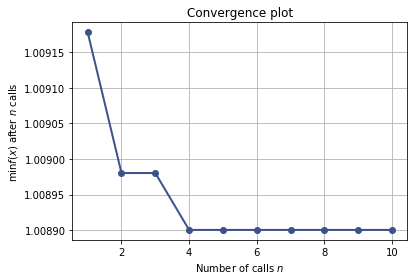

In [174]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [175]:
res_gp.x

[4,
 130,
 195.02460619317566,
 0.7686997271683054,
 0.6346565260900119,
 3.3769098780033415,
 190]